In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mate
import avstack
from scipy.stats import beta
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


No torch found.
MIDAS module not found.
Cannot use sklearn methods


/home/spencer/Documents/Projects/Research/multi-agent/multi-agent-trust-estimator/.venv/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Mapping CertainTrust to Beta

In [2]:
# system of linear equations
def map_f_to_opinion_init(f):
    """Underdetermined problem? s0 = (1-f)*r0 / f"""
    r0 = 1.0
    s0 = (1-f)*r0 / f
    return r0, s0


def map_ct_to_beta(t, c, f):
    r0, s0 = map_f_to_opinion_init(f)
    b = np.array([
        (t-1)*r0 + t*s0,
        (c-1)*r0 + (c-1)*s0 - 2*c,
    ])
    A = np.array([
        [t-1, 1],
        [c-1, c-1],
    ])
    x = np.linalg.solve(A, b)
    return x

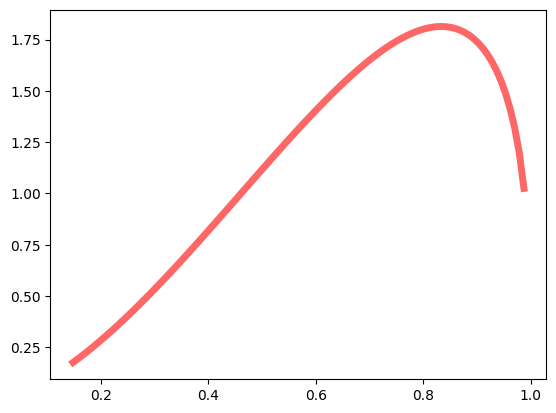

In [3]:
params = map_ct_to_beta(0.5, 0.5, 0.5)

fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0.01, params[0], params[1]),
                beta.ppf(0.99, params[0], params[1]), 100)
ax.plot(x, beta.pdf(x, params[0], params[1]),
       'r-', lw=5, alpha=0.6, label='beta pdf')


## Testing Cluster Scoring

In [70]:
import itertools
from avstack.geometry import Sphere, Position, GlobalOrigin3D


class FakeTrack:
    _ids = itertools.count()
    def __init__(self, xyz, probability):
        self.x = xyz
        self.probability = probability
        self.ID = next(FakeTrack._ids)
        self.reference = GlobalOrigin3D

    @property
    def position(self):
        return Position(self.x, reference=self.reference)

    def distance(self, other, check_reference=False):
        return np.linalg.norm(self.x - other.x)


n_agents_see = 2
n_agents_nosee = 0
agents = {k: None for k in range(n_agents_see + n_agents_nosee)}
fovs = {k: Sphere(radius=2) for k in agents}
tracks = {k: [FakeTrack(xyz=np.random.rand(3), probability=np.random.uniform(low=0.8, high=1.0))] for k in range(n_agents_see)}
clusterer = avstack.modules.clustering.SampledAssignmentClusterer(assign_radius=3)
cluster_scorer = mate.measurement.ClusterScorerV1()

An `WeightedAverageFuzzy` instance is built from registry, and its implementation can be found in mate.connectives


In [71]:
# get scores for clusters
clusters = clusterer(tracks, frame=0, timestamp=0)
prior = mate.measurement.UncertainTrustFloat(trust=0.5, confidence=0.5, prior=0.5, ID=clusters[0].ID)
taus = cluster_scorer(
    cluster=clusters[0],
    agents=None,
    poses=None,
    fovs=fovs,
    prior=prior,
    Pd=0.9
)
taus

def normalize(cs, exp=1):
    return cs**exp / sum(cs**exp)

# perform weighted combinations
ts = np.asarray([t.t for t in taus])
cs = np.asarray([t.c for t in taus])
w_norm = normalize(cs)
trust = ts @ w_norm
confidence = 1 - np.var(ts)

# print result
trust, confidence

(0.8893781200560167, 0.9444444444444444)